# Predicting scalar coupling constant between two atoms in different organic molecules

### Imports

In [3]:
import os
import pandas as pd
import inspect
from sklearn.pipeline import Pipeline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Activation, Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras import regularizers
from sklearn.metrics import mean_absolute_error as mae
from numpy.random import seed
import keras.backend as K
from keras.layers.normalization import BatchNormalization
from matplotlib import pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats as sp
from sklearn.externals.joblib import parallel_backend
import keras.backend as K
import tensorflow as tf
from sklearn.model_selection import ParameterSampler
from keras import optimizers
import random
from biopandas.mol2 import PandasMol2
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from skopt import BayesSearchCV
from skopt.space import Real
from skopt.space import Integer
from keras.callbacks import EarlyStopping
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.utils import use_named_args
import matplotlib.image as mpimg

Using TensorFlow backend.
/home/dionizije/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Data analysis

### Changing directory and setting seed for random operations

In [23]:
seed(0)
os.chdir('/home/dionizije/Desktop/Code/Predicting molecular properties')

### Loading the train set and structure of the molecules

In [13]:
train = pd.read_csv('train.csv', index_col = 'id') 
structures = pd.read_csv('structures.csv') 

In [15]:
train.head(5) #Data provided in the train set

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,dsgdb9nsd_000001,1,0,1JHC,84.8076
1,dsgdb9nsd_000001,1,2,2JHH,-11.2570
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543
4,dsgdb9nsd_000001,2,0,1JHC,84.8074


In [16]:
structures.head(5) #Data provided in the structure files

,molecule_name,atom_index,atom,x,y,z
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397


In [17]:
print('Missing values in training set = {}'.format(train.isnull().sum().sum())) 
print('Missing values in structures = {}'.format(structures.isnull().sum().sum()))

Missing values in training set = 0
Missing values in structures = 0


Checks for missing data in the structures and training set

In [23]:
print('Number of molecules in the training set molecules = {}'.format(train.molecule_name.nunique()))
print('Unique scalar coupling types = {}'.format(train.type.unique()))

Number of molecules in the training set molecules = 85003
Unique scalar coupling types = ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN']


### Distribution of the scalar coupling constant in the training data

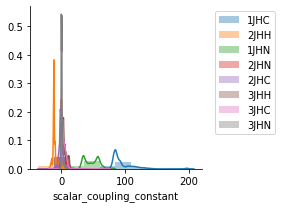

In [24]:
def distplot_with_hue(df, x, hue, hist=True, kde=True):
    _, bins = np.histogram(df[x])
    g = sns.FacetGrid(df, hue=hue)
    g = g.map(sns.distplot, x, bins=bins, hist=hist, kde=kde)
    g.ax.legend(loc=2, bbox_to_anchor=(1.05, 1))
    
distplot_with_hue(train, 'scalar_coupling_constant', 'type')

Distribution of the scalar coupling constant by molecules types -> some values are distinct while others are overlapped

### Extracting features from biopandas module --> Atom hybridization, distances, ligand types

In [27]:
def mol_2_files():
    """Features from biopandas from mol2/xyz structure files"""
    files = []
    for file in os.listdir('/home/dionizije/Desktop/Code/Predicting molecular properties/mol'):
        if file.endswith('.mol2'):
            files.append(file)
            
    molecules = []
    for molecule in files:
        try: #try statement, because there is a .mol2 file which is not a molecule and stops execution
            mol2_object = PandasMol2().read_mol2(path = '/home/dionizije/Desktop/Code/Predicting molecular properties/mol/' + molecule)
            molecule_name = molecule.rsplit(".", 1)[0] #gets rid of the extension
            molecule_name_column = [molecule_name] * int(len(mol2_object.df)) #list for molecule name column
            df_object = mol2_object.df #gets dataframe object
            df_object['molecule_name'] = molecule_name_column
            distances = mol2_object.distance() #distance from 0,0,0 reference point
            df_object['dist_from_refp'] = distances 
            df_object['atom_id'] = df_object['atom_id'] - 1 #changing indices to start from 0
            df_object.drop(['x', 'y', 'z'], axis = 1, inplace = True) #drops coordinates --> already in structures file
            df_object = df_object.rename(columns = {'atom_id': 'atom_index'})
            molecules.append(df_object) 
        except:
            pass
    df_molecules = pd.concat(molecules)
    return df_molecules

df_molecules = mol_2_files() 

In [28]:
df_molecules.head()

,atom_index,atom_name,atom_type,subst_id,subst_name,charge,molecule_name,dist_from_refp
0,0,C,C.3,1,LIG1,-0.0649,dsgdb9nsd_118835,1.565290
1,1,C,C.3,1,LIG1,-0.0504,dsgdb9nsd_118835,0.306451
2,2,C,C.3,1,LIG1,-0.0097,dsgdb9nsd_118835,1.522293
3,3,C,C.3,1,LIG1,-0.0182,dsgdb9nsd_118835,2.475827
4,4,C,C.3,1,LIG1,0.0714,dsgdb9nsd_118835,2.570540


In [29]:
df_molecules.to_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/df_molecules.csv')

Saving bigger dataframes to disk in case of memory crashes.

Merging features from df_molecules to structure files and adding structure information to the training set

In [30]:
def merge_mol2():
    """Merges molecules data from biopandas to structures file"""
    data = pd.merge(structures, df_molecules, how = 'left',
                    right_on = ['molecule_name', 'atom_index'],
                    left_on = ['molecule_name', 'atom_index'])
    data = data.drop(['atom_name', 'subst_id'], axis = 1)
    return data

structures = merge_mol2()
del(df_molecules) #del for releasing from memory


In [31]:
structures.head()

,molecule_name,atom_index,atom,x,y,z,atom_type,subst_name,charge,dist_from_refp
0,dsgdb9nsd_000001,0,C,-0.012698,1.085804,0.008001,C.3,LIG1,-0.0776,1.085904
1,dsgdb9nsd_000001,1,H,0.002150,-0.006031,0.001976,H,LIG1,0.0194,0.006696
2,dsgdb9nsd_000001,2,H,1.011731,1.463751,0.000277,H,LIG1,0.0194,1.779395
3,dsgdb9nsd_000001,3,H,-0.540815,1.447527,-0.876644,H,LIG1,0.0194,1.776555
4,dsgdb9nsd_000001,4,H,-0.523814,1.437933,0.906397,H,LIG1,0.0194,1.778619


In [32]:
def merge_structures(data, atom_index):
    """Merges atom data from structures to atom data in the training sets"""
    data = pd.merge(data, structures, how = 'left',
                    left_on = ['molecule_name', 'atom_index_{}'.format(atom_index)],
                    right_on = ['molecule_name', 'atom_index'])
    data = data.drop('atom_index', axis = 1)
    data = data.rename(columns = {'atom': 'atom_{}'.format(atom_index),
                                  'x': 'x_{}'.format(atom_index),
                                  'y': 'y_{}'.format(atom_index),
                                  'z': 'z_{}'.format(atom_index)})
    return data

train = merge_structures(train, 0)
train = merge_structures(train, 1)

In [33]:
train.head()

,molecule_name,atom_index_0,atom_index_1,type,scalar_coupling_constant,atom_0,x_0,y_0,z_0,atom_type_x,...,charge_x,dist_from_refp_x,atom_1,x_1,y_1,z_1,atom_type_y,subst_name_y,charge_y,dist_from_refp_y
0,dsgdb9nsd_000001,1,0,1JHC,84.8076,H,0.002150,-0.006031,0.001976,H,...,0.0194,0.006696,C,-0.012698,1.085804,0.008001,C.3,LIG1,-0.0776,1.085904
1,dsgdb9nsd_000001,1,2,2JHH,-11.2570,H,0.002150,-0.006031,0.001976,H,...,0.0194,0.006696,H,1.011731,1.463751,0.000277,H,LIG1,0.0194,1.779395
2,dsgdb9nsd_000001,1,3,2JHH,-11.2548,H,0.002150,-0.006031,0.001976,H,...,0.0194,0.006696,H,-0.540815,1.447527,-0.876644,H,LIG1,0.0194,1.776555
3,dsgdb9nsd_000001,1,4,2JHH,-11.2543,H,0.002150,-0.006031,0.001976,H,...,0.0194,0.006696,H,-0.523814,1.437933,0.906397,H,LIG1,0.0194,1.778619
4,dsgdb9nsd_000001,2,0,1JHC,84.8074,H,1.011731,1.463751,0.000277,H,...,0.0194,1.779395,C,-0.012698,1.085804,0.008001,C.3,LIG1,-0.0776,1.085904


In [34]:
train.to_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/train_final.csv')

In [35]:
del(structures)


Defining a function for adding additional features, and splitting the training set to features and target
Added features are distance between coupling atoms, dipole moments, atomic radius, electronegativity, angles between point vectors.
Categorical variables are one hot encoded.

In [25]:
def preprocessing_features(data):
    
    #Distance between coupling atoms
    data['dist_coupling_atoms'] = ((data['x_1'] - data['x_0'])**2 + (data['y_1'] - data['y_0'])**2 + (data['z_1'] - data['z_0'])**2)**1/2
    
    #adding dipole moments
    dipole_moments = pd.read_csv('dipole_moments.csv')
    data = pd.merge(data, dipole_moments, how = 'inner', left_on = ['molecule_name'],
                     right_on = ['molecule_name'])
    data.rename(columns  = {'X_x': 'X_dipole', 'Y_x': 'Y_dipole', 'Z_x': 'Z_dipole'}, inplace = True)
    
    #adding atomic radius
    atomic_radius = pd.DataFrame({'radius' : [67, 53, 56, 48, 42]},
                             index = ['C', 'H', 'N', 'O', 'F'])
    
    data = data.merge(atomic_radius, left_on = ['atom_0'], right_on = atomic_radius.index)
    data = data.rename(columns = {'atomic_radius' : 'radius_atom_0'})
    
    #adding atomic radius
    data = data.merge(atomic_radius, left_on = ['atom_1'], right_on = atomic_radius.index)
    data = data.rename(columns = {'atomic_radius' : 'radius_atom_1'})
    
    #adding electronegativity
    electronegativity = pd.DataFrame({'electronegativity' : [2.55, 2.20, 3.04, 3.44, 3.98]},
                                  index = ['C', 'H', 'N', 'O', 'F'])
    
    data = data.join(electronegativity, how = 'left', on = ['atom_0'])
    data = data.rename(columns = {'electronegativity' : 'electronegativity_atom_0'})
    
    #adding electronegativity
    data = data.join(electronegativity, how = 'left', on = ['atom_1'])
    data = data.rename(columns = {'electronegativity' : 'electronegativity_atom_1'})
    
    
    data.drop(columns = ['atom_index_0', 'atom_index_1', 'atom_0', 'atom_1'], inplace = True)
    
    #dummies and dropping columns
    X = data.drop(columns = 'molecule_name')
    X = pd.get_dummies(X, columns = ['type', 'atom_type_x', 'atom_type_y', 'subst_name_x',
                                     'subst_name_y'], drop_first = True)
    y = X['scalar_coupling_constant']
    X.drop(columns = 'scalar_coupling_constant', inplace = True)
    
    def calculate_angles(X):
        "Calculates angles between two unit vectors"""
        def unit_vector(vector):
            """ Returns the unit vector of the vector.  """
            return vector / np.linalg.norm(vector)
    
        def angle_btw_vectors(v1, v2):
            """ Returns the angle in radians between vectors 'v1' and 'v2'::"""
            v1_u = unit_vector(v1)
            v2_u = unit_vector(v2)
            return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))
    
        vectors_0 = []
        for i in range(0, len(X)):
            x = X['x_0'].iloc[i]
            y = X['y_0'].iloc[i]
            z = X['z_0'].iloc[i]
            vector_coords = [x, y, z]
            units = unit_vector(vector_coords)
            vectors_0.append(units)         
        
        vectors_1 = []
        for i in range(0, len(X)):
            x = X['x_1'].iloc[i]
            y = X['y_1'].iloc[i]
            z = X['z_1'].iloc[i]
            vector_coords = [x, y, z]
            units = unit_vector(vector_coords)
            vectors_1.append(units)
        
        angles = []
        for i in range(0, len(vectors_0)):
            angle = angle_btw_vectors(vectors_0[i], vectors_1[i])
            angles.append(angle)
            
        return angles
    
    angles = calculate_angles(X)
    X['angles'] = angles
    
    return X,y 

In [37]:
X, y = preprocessing_features(train)

In [38]:
X.head()

,x_0,y_0,z_0,charge_x,dist_from_refp_x,x_1,y_1,z_1,charge_y,dist_from_refp_y,...,subst_name_y_LEU1,subst_name_y_LIG1,subst_name_y_PRO1,subst_name_y_SER1,subst_name_y_THR1,subst_name_y_UNK0,subst_name_y_UNK1,subst_name_y_UNK2,subst_name_y_VAL1,angles
0,0.002150,-0.006031,0.001976,0.0194,0.006696,-0.012698,1.085804,0.008001,-0.0776,1.085904,...,0,1,0,0,0,0,0,0,0,2.694086
1,1.011731,1.463751,0.000277,0.0194,1.779395,-0.012698,1.085804,0.008001,-0.0776,1.085904,...,0,1,0,0,0,0,0,0,0,0.616520
2,-0.540815,1.447527,-0.876644,0.0194,1.776555,-0.012698,1.085804,0.008001,-0.0776,1.085904,...,0,1,0,0,0,0,0,0,0,0.618726
3,-0.523814,1.437933,0.906397,0.0194,1.778619,-0.012698,1.085804,0.008001,-0.0776,1.085904,...,0,1,0,0,0,0,0,0,0,0.617095
4,-0.027803,2.198949,0.014154,0.1537,2.199122,-0.013324,1.132466,0.008276,0.0464,1.132609,...,0,1,0,0,0,0,0,0,0,0.001237


In [39]:
del(train)
X.to_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/X_final.csv')
np.savetxt('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/y_final.csv', y, delimiter = ",", )

Setting aside data for testing

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)

X_train.to_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/X_train_final.csv')
np.savetxt('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/y_train_final.csv', y_train, delimiter = ",")

X_test.to_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/X_test_final.csv')
np.savetxt('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/y_test_final.csv', y_test, delimiter = ",")

## Model optimization

Functions for cross validation of the training set and mean absolute error between the predictions and the test set

In [43]:
def evaluation(model, X_train, y_train):
    """Cross validation on the training set"""
    model = KerasRegressor(build_fn = model, epochs = 50)
    scoring = ['neg_mean_squared_error', 'neg_mean_absolute_error']
    scores = pd.DataFrame(cross_validate(model, X_train, y_train, scoring = scoring, cv = 3))
    return scores

In [56]:
def test_evaluation(model, X_train, y_train, X_test, y_test):
    """Evaluation of the model (MAE) on the test set"""
    model = model()
    early_stopper = EarlyStopping(patience=15, monitor='val_loss', min_delta=0, mode='min', restore_best_weights = True)
    history = model.fit(X_train, y_train, callbacks = [early_stopper], validation_data = (X_test, y_test), epochs = 50)
    y_pred = model.predict(X_test)
    mean_absolute_error = mae(y_test, y_pred)
    print('Mean absolute error on the test set is {}'.format(mean_absolute_error))
    return mean_absolute_error, history

### Model with 1 hidden layer and Adam optimizer, all default values

In [57]:
def model_1():
    """ Baseline model + 1 hidden layer + dropout"""
    K.backend()
    model = Sequential()
    
    #input layer
    model.add(Dense(int(X_train.shape[1]), input_dim = int(X_train.shape[1])))
    model.add(Activation('relu'))
    
    #hidden layer
    model.add(Dense(int(X_train.shape[1]/2)))
    model.add(Activation('relu'))

    
    #output layer
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model

In [ ]:
X_train = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/X_train_final.csv', index_col = 0)
y_train = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/y_train_final.csv', header = None)
X_test = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/X_test_final.csv', index_col = 0)
y_test = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/y_test_final.csv', header = None)

#### Cross validation on the training set of the model with default parameters

In [ ]:
model_1_cross_valid_score = evaluation(model_1, X_train, y_train) #Calculates the cross validation scores

In [8]:
model_1_cross_valid_score = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_1.csv',
                                       index_col = [0])
model_1_cross_valid_score

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error
0,6841.771627,36.589580,-9.189185,-1.978522
1,6964.458209,31.311657,-10.181463,-2.116645
2,7324.525281,33.686052,-10.904482,-2.126167


#### Evaluating the model on the test set and plotting learning history

In [ ]:
model_1_mae, history_model_1 = test_evaluation(model_1, X_train, y_train, X_test, y_test) #Returns history and MAE on test set

In [9]:
model_1_mae_score = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_1_mae.csv',
                               index_col = [0])
model_1_mae_score

,model_1_mae
0,1.973654


Mean absolute error is basically the same as on the training set

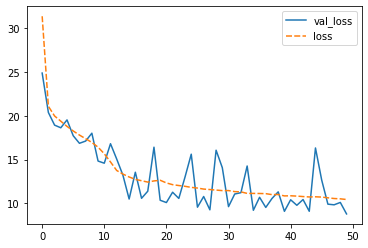

In [6]:
model_1_history = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_1_history.csv', 
                             index_col = [0])
sns.lineplot(data = model_1_history)

Model hasn't converged after 50 epochs, and the loss on the validation set is fluctuating, which should be improved with hyper-parameter optimization and regularization.

### Model 2 - default values with added batch normalization for regularization

In [12]:
def model_2():
    K.backend()
    model = Sequential()
    #input layer
    model.add(Dense(int(X_train.shape[1]), input_dim = int(X_train.shape[1])))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    
    #hidden layer
    model.add(Dense(int(X_train.shape[1]/2)))
    model.add(Activation('relu'))

    
    #output layer
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model

In [ ]:
model_2_cross_valid_score = evaluation(model_2, X_train, y_train) #Cross validation on the default model with BN

In [13]:
model_2_cross_valid_score = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_2.csv',
                                        index_col = [0])
model_2_cross_valid_score

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error
0,9037.327654,52.054146,-21.966199,-2.910550
1,9283.378555,45.239434,-20.786696,-2.856885
2,9487.053614,50.274308,-18.566012,-2.636477


With added batch normalization : training time is increased and the scores are worse than on the default model

In [14]:
model_2_mae_score = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_2_mae.csv',
                               index_col = [0])
model_2_mae_score

,model_2_mae
0,2.580056


Mean absolute error on the test set is also higher with batch normalization

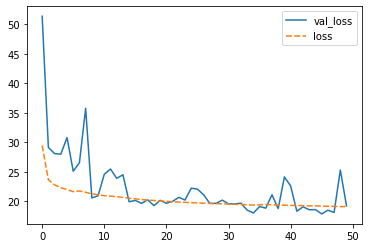

In [7]:
model_2_history = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_2_history.csv', 
                             index_col = [0])
sns.lineplot(data = model_2_history)

Fluctuation in validation set loss has been reduced, but at the cost of accuracy

In [13]:
model_histories = pd.DataFrame({'model_1_loss': model_1_history['loss'],
                                'model_2_loss': model_2_history['loss'], 
                                'model_1_val_loss': model_1_history['val_loss'], 
                                'model_2_val_loss': model_2_history['val_loss']})

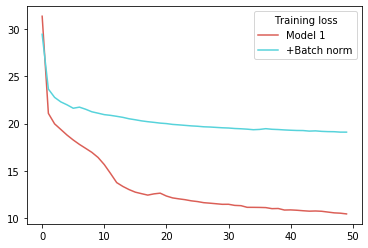

In [14]:
plot = sns.lineplot(data = [model_histories['model_1_loss'], model_histories['model_2_loss']],
                   palette=sns.color_palette("hls", 2), dashes = False)
labels = ['Model 1', '+ Batch norm']
plt.legend(title = 'Training loss', labels = ['Model 1', '+Batch norm'])


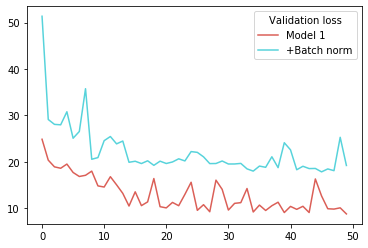

In [15]:
plot = sns.lineplot(data = [model_histories['model_1_val_loss'], model_histories['model_2_val_loss']],
                     palette=sns.color_palette("hls", 2), dashes = False)
labels = ['Model 1', '+ Batch norm']
plt.legend(title = 'Validation loss', labels = ['Model 1', '+Batch norm'])


Comparison plots of validation and training losses of models with and without batch normalization where it's clear that there are less fluctuations with batch normalization, but accuracy is lower

### Data subsampling for paramater tuning

In [22]:
def subsampling(data, number_of_samples):
    """ Samples the same number of values for each type to reduce memory issues and reduce training time"""
    
    unique_types = list(train['type'].unique())
    num_of_each_type = int(number_of_samples/len(unique_types))
    subsampled_types = []
    for types in unique_types:
        samples = train.query("type ==  '{}'".format(types)).sample(num_of_each_type)
        subsampled_types.append(samples)
    train_subsampled = pd.concat(subsampled_types)
    
    #Stats of scalar coupling constant
    data_distribution = pd.DataFrame(train['scalar_coupling_constant'].describe())
    data_distribution.rename(columns = {'scalar_coupling_constant': 'Train_scalar_coupling_constant'}, 
                             inplace = True)
    
    data_subsample_distribution = pd.DataFrame(train_subsampled['scalar_coupling_constant'].describe())
    data_subsample_distribution.rename(columns = {'scalar_coupling_constant': 'Train_subsample_scalar_coupling_constant'},
                                       inplace = True)
    
    #Distribution plot
    fig, ax = plt.subplots()
    sns.distplot(train['scalar_coupling_constant'], ax = ax, label = 'Train')
    sns.distplot(train_subsampled['scalar_coupling_constant'], ax = ax, label = 'Train_subsampled')
    ax.legend()
    plt.title('Distribution of whole train dataset vs subsampled')
    plt.show()
    
    print(data_distribution)
    print(data_subsample_distribution)
    return train_subsampled

In [24]:
train = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Features/train_final.csv', 
                   index_col = [0])

/home/dionizije/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


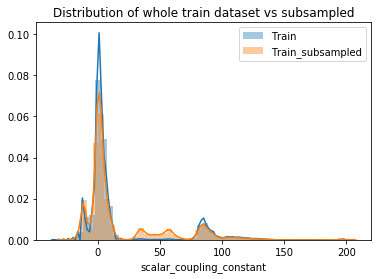

       Train_scalar_coupling_constant
count                    4.658147e+06
mean                     1.592165e+01
std                      3.494198e+01
min                     -3.621860e+01
25%                     -2.549780e-01
50%                      2.281130e+00
75%                      7.390655e+00
max                      2.048800e+02
       Train_subsample_scalar_coupling_constant
count                             300000.000000
mean                                  18.066605
std                                   34.188050
min                                  -26.899000
25%                                   -0.095366
50%                                    2.507215
75%                                   29.319300
max                                  202.129000


In [27]:
train_subsampled = subsampling(train, 300000)

Comparison of the distributions of scalar coupling constant in the whole training set and the subsampled training set. 

In [29]:
X_subsampled, y_subsampled = preprocessing_features(train_subsampled)
y_subsampled = y_subsampled.values.reshape(-1,1)

#### Cross validation of model 1 on subsampled data

In [30]:
def model_1_subsampled():
    """ Baseline model + 1 hidden layer + dropout"""
    K.backend()
    model = Sequential()
    
    #input layer
    model.add(Dense(int(X_subsampled.shape[1]), input_dim = int(X_subsampled.shape[1])))
    model.add(Activation('relu'))
    
    #hidden layer
    model.add(Dense(int(X_subsampled.shape[1]/2)))
    model.add(Activation('relu'))

    
    #output layer
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model

In [44]:
model_1_score_subsampled = evaluation(model_1_subsampled, X_subsampled, y_subsampled)

Epoch 1/50
200000/200000 [==============================] - 31s 154us/step - loss: 32.2744
Epoch 2/50
200000/200000 [==============================] - 31s 154us/step - loss: 13.7282
Epoch 3/50
200000/200000 [==============================] - 31s 155us/step - loss: 13.1197
Epoch 4/50
200000/200000 [==============================] - 31s 154us/step - loss: 12.6416
Epoch 5/50
200000/200000 [==============================] - 31s 154us/step - loss: 12.0329
Epoch 6/50
200000/200000 [==============================] - 31s 154us/step - loss: 11.3974
Epoch 7/50
200000/200000 [==============================] - 31s 154us/step - loss: 10.8701
Epoch 8/50
200000/200000 [==============================] - 31s 153us/step - loss: 10.4468
Epoch 9/50
200000/200000 [==============================] - 31s 154us/step - loss: 10.0309
Epoch 10/50
200000/200000 [==============================] - 31s 153us/step - loss: 9.6223
Epoch 11/50
200000/200000 [==============================] - 30s 151us/step - loss: 9.2551

In [45]:
model_1_score_subsampled

,fit_time,score_time,test_neg_mean_squared_error,test_neg_mean_absolute_error
0,1532.407646,6.323515,-5544.947285,-46.531128
1,1488.996960,7.011984,-11.016185,-2.179924
2,1507.588302,7.084641,-544.430985,-15.630765


Large difference between MSE on the training and test folds; model is overfitting and there is a lot of fluctuation between folds. 

#### Grid search of kernel initializers and number of neurons in the hidden layer on the subsampled data

In [49]:
def model_2_subsampled(kernel_init_1, kernel_init_2, kernel_init_3):
    K.backend()
    model = Sequential()
    
    #input layer
    model.add(Dense(int(X_subsampled.shape[1]), input_dim = int(X_subsampled.shape[1]),
                    kernel_initializer = kernel_init_1))
    model.add(Activation('relu'))
    
    #hidden layer
    model.add(Dense(int(X_subsampled.shape[1]/2), kernel_initializer = kernel_init_2))
    model.add(Activation('relu'))

    
    #output layer
    model.add(Dense(1, kernel_initializer = kernel_init_3))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model

In [50]:
model = KerasRegressor(build_fn = model_2_subsampled, epochs = 50)
parameters = {'kernel_init_1': ['glorot_normal', 'he_normal'],
              'kernel_init_2': ['glorot_normal', 'he_normal'],
              'kernel_init_3': ['glorot_normal', 'he_normal']}
grid_search = GridSearchCV(model, param_grid = parameters,
                           n_jobs = 1, cv = 3, iid = False, scoring = 'neg_mean_squared_error')
grid_search.fit(X_subsampled, y_subsampled)
grid_search_init_results_df = pd.DataFrame(grid_search.cv_results_)
init_best_params = grid_search.best_params_

Epoch 1/50
200000/200000 [==============================] - 46s 231us/step - loss: 31.2294
Epoch 2/50
200000/200000 [==============================] - 43s 216us/step - loss: 14.4507
Epoch 3/50
200000/200000 [==============================] - 43s 216us/step - loss: 13.6971
Epoch 4/50
200000/200000 [==============================] - 43s 216us/step - loss: 13.1604
Epoch 5/50
200000/200000 [==============================] - 44s 218us/step - loss: 12.5746
Epoch 6/50
200000/200000 [==============================] - 44s 219us/step - loss: 11.8828
Epoch 7/50
200000/200000 [==============================] - 44s 222us/step - loss: 11.3099
Epoch 8/50
200000/200000 [==============================] - 44s 220us/step - loss: 10.9363
Epoch 9/50
200000/200000 [==============================] - 44s 219us/step - loss: 10.6166
Epoch 10/50
200000/200000 [==============================] - 45s 223us/step - loss: 10.2929
Epoch 11/50
200000/200000 [==============================] - 44s 219us/step - loss: 9.903

200000/200000 [==============================] - 44s 219us/step - loss: 7.3505
Epoch 30/50
200000/200000 [==============================] - 44s 220us/step - loss: 7.3215
Epoch 31/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.2555
Epoch 32/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.2170
Epoch 33/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.2060
Epoch 34/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.1862
Epoch 35/50
200000/200000 [==============================] - 44s 218us/step - loss: 7.1456
Epoch 36/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.0847
Epoch 37/50
200000/200000 [==============================] - 44s 218us/step - loss: 7.0641
Epoch 38/50
200000/200000 [==============================] - 44s 219us/step - loss: 7.0699
Epoch 39/50
200000/200000 [==============================] - 44s 218us/step - loss: 7.0107
Epoch 40/50

200000/200000 [==============================] - 44s 222us/step - loss: 29.9652
Epoch 8/50
200000/200000 [==============================] - 44s 222us/step - loss: 29.1596
Epoch 9/50
200000/200000 [==============================] - 44s 222us/step - loss: 28.0605
Epoch 10/50
200000/200000 [==============================] - 45s 223us/step - loss: 27.2156
Epoch 11/50
200000/200000 [==============================] - 44s 222us/step - loss: 26.4462
Epoch 12/50
200000/200000 [==============================] - 44s 221us/step - loss: 25.9548
Epoch 13/50
200000/200000 [==============================] - 44s 222us/step - loss: 25.4955
Epoch 14/50
200000/200000 [==============================] - 44s 222us/step - loss: 25.1657
Epoch 15/50
200000/200000 [==============================] - 44s 222us/step - loss: 24.8439
Epoch 16/50
200000/200000 [==============================] - 44s 221us/step - loss: 24.5765
Epoch 17/50
200000/200000 [==============================] - 44s 222us/step - loss: 24.4149
Ep

200000/200000 [==============================] - 45s 225us/step - loss: 23.0559
Epoch 36/50
200000/200000 [==============================] - 45s 226us/step - loss: 22.8607
Epoch 37/50
200000/200000 [==============================] - 45s 225us/step - loss: 22.7088
Epoch 38/50
200000/200000 [==============================] - 45s 226us/step - loss: 22.5848
Epoch 39/50
200000/200000 [==============================] - 45s 226us/step - loss: 22.5558
Epoch 40/50
200000/200000 [==============================] - 45s 226us/step - loss: 22.6020
Epoch 41/50
200000/200000 [==============================] - 45s 226us/step - loss: 22.5279
Epoch 42/50
200000/200000 [==============================] - 45s 225us/step - loss: 22.4455
Epoch 43/50
200000/200000 [==============================] - 45s 225us/step - loss: 22.3579
Epoch 44/50
200000/200000 [==============================] - 45s 225us/step - loss: 22.4103
Epoch 45/50
200000/200000 [==============================] - 45s 225us/step - loss: 22.3680


200000/200000 [==============================] - 46s 228us/step - loss: 28.4574
Epoch 14/50
200000/200000 [==============================] - 46s 228us/step - loss: 28.0284
Epoch 15/50
200000/200000 [==============================] - 46s 228us/step - loss: 27.6467
Epoch 16/50
200000/200000 [==============================] - 46s 228us/step - loss: 27.3912
Epoch 17/50
200000/200000 [==============================] - 46s 228us/step - loss: 27.1019
Epoch 18/50
200000/200000 [==============================] - 46s 228us/step - loss: 26.9736
Epoch 19/50
200000/200000 [==============================] - 46s 228us/step - loss: 26.7395
Epoch 20/50
200000/200000 [==============================] - 46s 229us/step - loss: 26.6643
Epoch 21/50
200000/200000 [==============================] - 46s 228us/step - loss: 26.5043
Epoch 22/50
200000/200000 [==============================] - 46s 228us/step - loss: 26.3840
Epoch 23/50
200000/200000 [==============================] - 46s 229us/step - loss: 26.1757


200000/200000 [==============================] - 46s 231us/step - loss: 24.1558
Epoch 42/50
200000/200000 [==============================] - 46s 231us/step - loss: 23.9487
Epoch 43/50
200000/200000 [==============================] - 46s 232us/step - loss: 23.9633
Epoch 44/50
200000/200000 [==============================] - 47s 236us/step - loss: 23.7676
Epoch 45/50
200000/200000 [==============================] - 47s 237us/step - loss: 23.6895
Epoch 46/50
200000/200000 [==============================] - 46s 231us/step - loss: 23.6390
Epoch 47/50
200000/200000 [==============================] - 46s 232us/step - loss: 23.6257
Epoch 48/50
200000/200000 [==============================] - 46s 232us/step - loss: 23.5318
Epoch 49/50
200000/200000 [==============================] - 46s 232us/step - loss: 23.3834
Epoch 50/50
200000/200000 [==============================] - 47s 233us/step - loss: 23.2964
Epoch 1/50
200000/200000 [==============================] - 51s 254us/step - loss: 32.1293
E

200000/200000 [==============================] - 47s 237us/step - loss: 8.4561
Epoch 20/50
200000/200000 [==============================] - 47s 237us/step - loss: 8.1879
Epoch 21/50
200000/200000 [==============================] - 47s 236us/step - loss: 8.0813
Epoch 22/50
200000/200000 [==============================] - 47s 236us/step - loss: 7.8700
Epoch 23/50
200000/200000 [==============================] - 47s 236us/step - loss: 7.7185
Epoch 24/50
200000/200000 [==============================] - 47s 236us/step - loss: 7.5480
Epoch 25/50
200000/200000 [==============================] - 47s 236us/step - loss: 7.4795
Epoch 26/50
200000/200000 [==============================] - 47s 237us/step - loss: 7.4104
Epoch 27/50
200000/200000 [==============================] - 47s 236us/step - loss: 7.3028
Epoch 28/50
200000/200000 [==============================] - 47s 236us/step - loss: 7.2246
Epoch 29/50
200000/200000 [==============================] - 47s 235us/step - loss: 7.1390
Epoch 30/50

300000/300000 [==============================] - 74s 248us/step - loss: 17.4053
Epoch 48/50
300000/300000 [==============================] - 74s 248us/step - loss: 17.3416
Epoch 49/50
300000/300000 [==============================] - 74s 247us/step - loss: 17.3620
Epoch 50/50
300000/300000 [==============================] - 74s 248us/step - loss: 17.2599


In [51]:
grid_search_init_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_kernel_init_1,param_kernel_init_2,param_kernel_init_3,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2162.998483,22.988251,9.443983,0.080097,glorot_normal,glorot_normal,glorot_normal,"{'kernel_init_1': 'glorot_normal', 'kernel_ini...",-3678.384330,-10.890664,-534.520635,-1407.931877,1619.621940,8
1,2191.773942,8.513757,9.816837,0.113805,glorot_normal,glorot_normal,he_normal,"{'kernel_init_1': 'glorot_normal', 'kernel_ini...",-1530.845387,-13.286260,-651.501891,-731.877846,622.142345,3
2,2209.832535,6.167361,10.051025,0.070929,glorot_normal,he_normal,glorot_normal,"{'kernel_init_1': 'glorot_normal', 'kernel_ini...",-1706.669540,-10.113611,-216.029634,-644.270928,755.918188,1
3,2254.650646,9.665379,10.786780,0.806877,glorot_normal,he_normal,he_normal,"{'kernel_init_1': 'glorot_normal', 'kernel_ini...",-2429.271145,-11.293878,-594.965463,-1011.843495,1030.208389,7
4,2285.935818,5.798310,10.653390,0.096139,he_normal,glorot_normal,glorot_normal,"{'kernel_init_1': 'he_normal', 'kernel_init_2'...",-2296.238739,-11.812195,-469.966500,-926.005811,986.789423,6
5,2314.357091,12.038404,11.191944,0.498828,he_normal,glorot_normal,he_normal,"{'kernel_init_1': 'he_normal', 'kernel_init_2'...",-2267.145413,-10.518101,-135.236608,-804.300041,1035.640257,5
6,2361.017928,17.498182,12.129472,0.449509,he_normal,he_normal,glorot_normal,"{'kernel_init_1': 'he_normal', 'kernel_init_2'...",-1826.922889,-11.855988,-443.769897,-760.849591,774.175524,4
7,2431.642772,42.376000,13.078689,0.793008,he_normal,he_normal,he_normal,"{'kernel_init_1': 'he_normal', 'kernel_init_2'...",-2029.001743,-11.227399,-124.495558,-721.574900,925.646128,2


Errors much higher than on the complete test set, still large fluctuations between folds

#### Random search dropout rade and hidden layer neurons

In [52]:
init_best_params

{'kernel_init_1': 'glorot_normal',
 'kernel_init_2': 'he_normal',
 'kernel_init_3': 'glorot_normal'}

In [53]:
def model_3_subsampled(dropout_rate_1, dropout_rate_2, neurons):
    K.backend()
    model = Sequential()
    
    #input layer
    model.add(Dense(int(X_subsampled.shape[1]), input_dim = int(X_subsampled.shape[1]),
                    kernel_initializer = 'glorot_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(rate = dropout_rate_1))
    
    #hidden layer
    model.add(Dense(neurons, kernel_initializer = 'he_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(rate = dropout_rate_2))

    
    #output layer
    model.add(Dense(1, kernel_initializer = 'glorot_normal'))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model


In [56]:
model = KerasRegressor(build_fn = model_3_subsampled)

dropout_rate_1 = list(np.random.uniform(0.0, 0.7, 100))
dropout_rate_2 = list(np.random.uniform(0.0, 0.5, 100))
param_dist = {'dropout_rate_1' : dropout_rate_1,
              'dropout_rate_2' : dropout_rate_2,
              'neurons' : sp.randint(2, int(X_subsampled.shape[1]))}

random_search = RandomizedSearchCV(model, param_distributions = param_dist,
                                       n_iter = 15, cv = 3, iid = False, scoring = 'neg_mean_squared_error')
random_search.fit(X_subsampled, y_subsampled, epochs = 50)
random_search_results_df = pd.DataFrame(random_search.cv_results_)
random_search_best_param = random_search.best_params_


W0831 19:01:55.860208 139810756114240 deprecation.py:506] From /home/dionizije/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Epoch 1/50
200000/200000 [==============================] - 57s 286us/step - loss: 44.9044
Epoch 2/50
200000/200000 [==============================] - 53s 265us/step - loss: 21.9651
Epoch 3/50
200000/200000 [==============================] - 53s 264us/step - loss: 19.7680
Epoch 4/50
200000/200000 [==============================] - 53s 263us/step - loss: 18.6230
Epoch 5/50
200000/200000 [==============================] - 53s 263us/step - loss: 17.8343
Epoch 6/50
200000/200000 [==============================] - 52s 262us/step - loss: 17.4629
Epoch 7/50
200000/200000 [==============================] - 53s 263us/step - loss: 17.3197
Epoch 8/50
200000/200000 [==============================] - 53s 263us/step - loss: 17.1884
Epoch 9/50
200000/200000 [==============================] - 52s 262us/step - loss: 17.0018
Epoch 10/50
200000/200000 [==============================] - 52s 262us/step - loss: 16.7054
Epoch 11/50
200000/200000 [==============================] - 52s 262us/step - loss: 16.72

200000/200000 [==============================] - 53s 265us/step - loss: 18.9753
Epoch 30/50
200000/200000 [==============================] - 53s 265us/step - loss: 19.0378
Epoch 31/50
200000/200000 [==============================] - 53s 264us/step - loss: 19.2317
Epoch 32/50
200000/200000 [==============================] - 53s 264us/step - loss: 18.8460
Epoch 33/50
200000/200000 [==============================] - 53s 265us/step - loss: 18.9074
Epoch 34/50
200000/200000 [==============================] - 53s 265us/step - loss: 18.8281
Epoch 35/50
200000/200000 [==============================] - 53s 265us/step - loss: 18.6374
Epoch 36/50
200000/200000 [==============================] - 53s 265us/step - loss: 18.7987
Epoch 37/50
200000/200000 [==============================] - 53s 265us/step - loss: 18.7858
Epoch 38/50
200000/200000 [==============================] - 53s 265us/step - loss: 18.6712
Epoch 39/50
200000/200000 [==============================] - 53s 266us/step - loss: 18.7308


200000/200000 [==============================] - 54s 268us/step - loss: 47.6432
Epoch 8/50
200000/200000 [==============================] - 54s 269us/step - loss: 46.3259
Epoch 9/50
200000/200000 [==============================] - 54s 269us/step - loss: 46.9444
Epoch 10/50
200000/200000 [==============================] - 54s 268us/step - loss: 45.4573
Epoch 11/50
200000/200000 [==============================] - 54s 268us/step - loss: 44.7932
Epoch 12/50
200000/200000 [==============================] - 54s 269us/step - loss: 44.4682
Epoch 13/50
200000/200000 [==============================] - 54s 268us/step - loss: 43.6400
Epoch 14/50
200000/200000 [==============================] - 54s 269us/step - loss: 43.1691
Epoch 15/50
200000/200000 [==============================] - 54s 268us/step - loss: 42.4644
Epoch 16/50
200000/200000 [==============================] - 54s 268us/step - loss: 42.4793
Epoch 17/50
200000/200000 [==============================] - 54s 268us/step - loss: 41.5942
Ep

200000/200000 [==============================] - 55s 274us/step - loss: 128.6713
Epoch 36/50
200000/200000 [==============================] - 55s 274us/step - loss: 125.6879
Epoch 37/50
200000/200000 [==============================] - 55s 274us/step - loss: 127.0242
Epoch 38/50
200000/200000 [==============================] - 55s 274us/step - loss: 126.1169
Epoch 39/50
200000/200000 [==============================] - 55s 274us/step - loss: 127.6465
Epoch 40/50
200000/200000 [==============================] - 55s 275us/step - loss: 127.6540
Epoch 41/50
200000/200000 [==============================] - 55s 275us/step - loss: 127.2186
Epoch 42/50
200000/200000 [==============================] - 55s 274us/step - loss: 128.1328
Epoch 43/50
200000/200000 [==============================] - 55s 274us/step - loss: 128.1774
Epoch 44/50
200000/200000 [==============================] - 55s 275us/step - loss: 127.8208
Epoch 45/50
200000/200000 [==============================] - 55s 274us/step - loss

200000/200000 [==============================] - 55s 276us/step - loss: 100.4789
Epoch 13/50
200000/200000 [==============================] - 55s 276us/step - loss: 101.9168
Epoch 14/50
200000/200000 [==============================] - 55s 276us/step - loss: 100.0487
Epoch 15/50
200000/200000 [==============================] - 55s 277us/step - loss: 98.8929
Epoch 16/50
200000/200000 [==============================] - 55s 275us/step - loss: 99.7375
Epoch 17/50
200000/200000 [==============================] - 55s 276us/step - loss: 99.8946
Epoch 18/50
200000/200000 [==============================] - 55s 276us/step - loss: 98.7222
Epoch 19/50
200000/200000 [==============================] - 55s 276us/step - loss: 100.0007
Epoch 20/50
200000/200000 [==============================] - 55s 277us/step - loss: 98.7569
Epoch 21/50
200000/200000 [==============================] - 55s 276us/step - loss: 99.2182
Epoch 22/50
200000/200000 [==============================] - 55s 275us/step - loss: 99.4

200000/200000 [==============================] - 56s 280us/step - loss: 60.0757
Epoch 41/50
200000/200000 [==============================] - 56s 280us/step - loss: 60.0413
Epoch 42/50
200000/200000 [==============================] - 56s 280us/step - loss: 60.0203
Epoch 43/50
200000/200000 [==============================] - 56s 279us/step - loss: 59.4057
Epoch 44/50
200000/200000 [==============================] - 56s 280us/step - loss: 59.9095
Epoch 45/50
200000/200000 [==============================] - 56s 279us/step - loss: 60.4765
Epoch 46/50
200000/200000 [==============================] - 56s 280us/step - loss: 60.0159
Epoch 47/50
200000/200000 [==============================] - 56s 279us/step - loss: 60.2124
Epoch 48/50
200000/200000 [==============================] - 56s 282us/step - loss: 59.3610
Epoch 49/50
200000/200000 [==============================] - 56s 280us/step - loss: 59.1364
Epoch 50/50
200000/200000 [==============================] - 56s 279us/step - loss: 59.3705


200000/200000 [==============================] - 57s 283us/step - loss: 25.9067
Epoch 19/50
200000/200000 [==============================] - 57s 284us/step - loss: 25.7836
Epoch 20/50
200000/200000 [==============================] - 54s 271us/step - loss: 26.0324
Epoch 21/50
200000/200000 [==============================] - 54s 270us/step - loss: 25.9419
Epoch 22/50
200000/200000 [==============================] - 57s 283us/step - loss: 25.7348
Epoch 23/50
200000/200000 [==============================] - 57s 284us/step - loss: 25.9138
Epoch 24/50
200000/200000 [==============================] - 57s 283us/step - loss: 26.0875
Epoch 25/50
200000/200000 [==============================] - 57s 283us/step - loss: 25.6110
Epoch 26/50
200000/200000 [==============================] - 56s 278us/step - loss: 25.7518
Epoch 27/50
200000/200000 [==============================] - 56s 279us/step - loss: 25.6247
Epoch 28/50
200000/200000 [==============================] - 56s 278us/step - loss: 25.6129


200000/200000 [==============================] - 58s 288us/step - loss: 22.1718
Epoch 47/50
200000/200000 [==============================] - 57s 286us/step - loss: 22.2901
Epoch 48/50
200000/200000 [==============================] - 57s 287us/step - loss: 22.1567
Epoch 49/50
200000/200000 [==============================] - 57s 286us/step - loss: 22.2200
Epoch 50/50
200000/200000 [==============================] - 57s 287us/step - loss: 22.0799
Epoch 1/50
200000/200000 [==============================] - 63s 313us/step - loss: 205.8557
Epoch 2/50
200000/200000 [==============================] - 54s 272us/step - loss: 102.9525
Epoch 3/50
200000/200000 [==============================] - 56s 281us/step - loss: 84.8457
Epoch 4/50
200000/200000 [==============================] - 58s 291us/step - loss: 73.7419
Epoch 5/50
200000/200000 [==============================] - 58s 291us/step - loss: 68.6147
Epoch 6/50
200000/200000 [==============================] - 58s 289us/step - loss: 68.3857
Epoc

W0901 15:53:09.579241 139810756114240 nn_ops.py:4224] Large dropout rate: 0.668266 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/50
200000/200000 [==============================] - 64s 320us/step - loss: 66.5883
Epoch 2/50
200000/200000 [==============================] - 58s 290us/step - loss: 23.9357
Epoch 3/50
200000/200000 [==============================] - 58s 290us/step - loss: 22.5566
Epoch 4/50
200000/200000 [==============================] - 58s 290us/step - loss: 21.9257
Epoch 5/50
200000/200000 [==============================] - 58s 289us/step - loss: 21.1654
Epoch 6/50
200000/200000 [==============================] - 58s 289us/step - loss: 20.7920
Epoch 7/50
200000/200000 [==============================] - 58s 290us/step - loss: 20.7958
Epoch 8/50
200000/200000 [==============================] - 58s 289us/step - loss: 20.6951
Epoch 9/50
200000/200000 [==============================] - 58s 289us/step - loss: 20.7691
Epoch 10/50
200000/200000 [==============================] - 58s 290us/step - loss: 20.7744
Epoch 11/50
200000/200000 [==============================] - 58s 291us/step - loss: 21.08

W0901 16:41:44.926158 139810756114240 nn_ops.py:4224] Large dropout rate: 0.668266 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/50
200000/200000 [==============================] - 64s 321us/step - loss: 253.1848
Epoch 2/50
200000/200000 [==============================] - 59s 293us/step - loss: 89.4489
Epoch 3/50
200000/200000 [==============================] - 58s 291us/step - loss: 74.3780
Epoch 4/50
200000/200000 [==============================] - 59s 294us/step - loss: 65.6942
Epoch 5/50
200000/200000 [==============================] - 59s 293us/step - loss: 62.1733
Epoch 6/50
200000/200000 [==============================] - 58s 290us/step - loss: 60.6614
Epoch 7/50
200000/200000 [==============================] - 58s 290us/step - loss: 58.9139
Epoch 8/50
200000/200000 [==============================] - 59s 293us/step - loss: 56.8251
Epoch 9/50
200000/200000 [==============================] - 58s 291us/step - loss: 55.6708
Epoch 10/50
200000/200000 [==============================] - 58s 290us/step - loss: 54.3022
Epoch 11/50
200000/200000 [==============================] - 58s 291us/step - loss: 53.8

W0901 17:30:27.496328 139810756114240 nn_ops.py:4224] Large dropout rate: 0.668266 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/50
200000/200000 [==============================] - 64s 322us/step - loss: 237.1539
Epoch 2/50
200000/200000 [==============================] - 58s 292us/step - loss: 87.9371
Epoch 3/50
200000/200000 [==============================] - 58s 292us/step - loss: 72.6369
Epoch 4/50
200000/200000 [==============================] - 58s 292us/step - loss: 64.5186
Epoch 5/50
200000/200000 [==============================] - 58s 291us/step - loss: 60.1606
Epoch 6/50
200000/200000 [==============================] - 58s 291us/step - loss: 58.9027
Epoch 7/50
200000/200000 [==============================] - 58s 291us/step - loss: 57.9252
Epoch 8/50
200000/200000 [==============================] - 58s 291us/step - loss: 55.9862
Epoch 9/50
200000/200000 [==============================] - 58s 291us/step - loss: 56.0785
Epoch 10/50
200000/200000 [==============================] - 58s 291us/step - loss: 54.4332
Epoch 11/50
200000/200000 [==============================] - 59s 294us/step - loss: 53.5

200000/200000 [==============================] - 60s 301us/step - loss: 123.6841
Epoch 29/50
200000/200000 [==============================] - 60s 301us/step - loss: 124.0881
Epoch 30/50
200000/200000 [==============================] - 60s 302us/step - loss: 123.8310
Epoch 31/50
200000/200000 [==============================] - 62s 312us/step - loss: 121.9940
Epoch 32/50
200000/200000 [==============================] - 61s 304us/step - loss: 123.1394
Epoch 33/50
200000/200000 [==============================] - 59s 297us/step - loss: 122.2692
Epoch 34/50
200000/200000 [==============================] - 61s 304us/step - loss: 123.1441
Epoch 35/50
200000/200000 [==============================] - 60s 298us/step - loss: 122.9014
Epoch 36/50
200000/200000 [==============================] - 61s 303us/step - loss: 123.1921
Epoch 37/50
200000/200000 [==============================] - 60s 299us/step - loss: 122.3533
Epoch 38/50
200000/200000 [==============================] - 59s 294us/step - loss

Epoch 17/50
200000/200000 [==============================] - 60s 299us/step - loss: 180.1075
Epoch 18/50
200000/200000 [==============================] - 59s 296us/step - loss: 181.5626
Epoch 19/50
200000/200000 [==============================] - 60s 298us/step - loss: 180.7567
Epoch 20/50
200000/200000 [==============================] - 60s 298us/step - loss: 179.7896
Epoch 21/50
200000/200000 [==============================] - 60s 300us/step - loss: 180.9741
Epoch 22/50
200000/200000 [==============================] - 59s 297us/step - loss: 178.4931
Epoch 23/50
200000/200000 [==============================] - 60s 300us/step - loss: 179.4722
Epoch 24/50
200000/200000 [==============================] - 60s 298us/step - loss: 180.5335
Epoch 25/50
200000/200000 [==============================] - 59s 297us/step - loss: 177.6649
Epoch 26/50
200000/200000 [==============================] - 59s 297us/step - loss: 179.6585
Epoch 27/50
200000/200000 [==============================] - 60s 298us

200000/200000 [==============================] - 60s 300us/step - loss: 31.2177
Epoch 45/50
200000/200000 [==============================] - 60s 300us/step - loss: 30.8831
Epoch 46/50
200000/200000 [==============================] - 60s 299us/step - loss: 31.1374
Epoch 47/50
200000/200000 [==============================] - 60s 300us/step - loss: 30.9545
Epoch 48/50
200000/200000 [==============================] - 60s 298us/step - loss: 30.8657
Epoch 49/50
200000/200000 [==============================] - 60s 299us/step - loss: 30.9240
Epoch 50/50
200000/200000 [==============================] - 60s 300us/step - loss: 30.8161
Epoch 1/50
200000/200000 [==============================] - 67s 334us/step - loss: 134.0363
Epoch 2/50
200000/200000 [==============================] - 60s 301us/step - loss: 51.0218
Epoch 3/50
200000/200000 [==============================] - 60s 301us/step - loss: 45.2130
Epoch 4/50
200000/200000 [==============================] - 60s 301us/step - loss: 44.0247
Epo

W0902 01:56:04.294224 139810756114240 nn_ops.py:4224] Large dropout rate: 0.540467 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/50
200000/200000 [==============================] - 67s 335us/step - loss: 88.4676
Epoch 2/50
200000/200000 [==============================] - 60s 302us/step - loss: 49.9472
Epoch 3/50
200000/200000 [==============================] - 61s 303us/step - loss: 46.9545
Epoch 4/50
200000/200000 [==============================] - 61s 303us/step - loss: 45.3315
Epoch 5/50
200000/200000 [==============================] - 60s 302us/step - loss: 44.4100
Epoch 6/50
200000/200000 [==============================] - 60s 301us/step - loss: 42.9971
Epoch 7/50
200000/200000 [==============================] - 61s 303us/step - loss: 42.2960
Epoch 8/50
200000/200000 [==============================] - 60s 302us/step - loss: 42.2269
Epoch 9/50
200000/200000 [==============================] - 60s 302us/step - loss: 41.9184
Epoch 10/50
200000/200000 [==============================] - 61s 303us/step - loss: 41.7799
Epoch 11/50
200000/200000 [==============================] - 60s 302us/step - loss: 41.67

W0902 02:46:49.077591 139810756114240 nn_ops.py:4224] Large dropout rate: 0.540467 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


Epoch 1/50
200000/200000 [==============================] - 68s 338us/step - loss: 343.2418
Epoch 2/50
200000/200000 [==============================] - 61s 305us/step - loss: 183.0144
Epoch 3/50
200000/200000 [==============================] - 61s 304us/step - loss: 163.2428
Epoch 4/50
200000/200000 [==============================] - 61s 303us/step - loss: 147.7355
Epoch 5/50
200000/200000 [==============================] - 60s 302us/step - loss: 139.2725
Epoch 6/50
200000/200000 [==============================] - 61s 304us/step - loss: 137.7758
Epoch 7/50
200000/200000 [==============================] - 61s 303us/step - loss: 134.1111
Epoch 8/50
200000/200000 [==============================] - 61s 305us/step - loss: 134.7515
Epoch 9/50
200000/200000 [==============================] - 61s 304us/step - loss: 131.0539
Epoch 10/50
200000/200000 [==============================] - 61s 303us/step - loss: 129.7981
Epoch 11/50
200000/200000 [==============================] - 61s 303us/step - l

200000/200000 [==============================] - 61s 306us/step - loss: 89.6560
Epoch 29/50
200000/200000 [==============================] - 61s 306us/step - loss: 89.0655
Epoch 30/50
200000/200000 [==============================] - 61s 306us/step - loss: 88.6434
Epoch 31/50
200000/200000 [==============================] - 61s 306us/step - loss: 88.0968
Epoch 32/50
200000/200000 [==============================] - 61s 306us/step - loss: 89.0408
Epoch 33/50
200000/200000 [==============================] - 61s 307us/step - loss: 88.9587
Epoch 34/50
200000/200000 [==============================] - 61s 307us/step - loss: 87.8649
Epoch 35/50
200000/200000 [==============================] - 61s 306us/step - loss: 86.9748
Epoch 36/50
200000/200000 [==============================] - 61s 305us/step - loss: 87.5983
Epoch 37/50
200000/200000 [==============================] - 61s 306us/step - loss: 86.0380
Epoch 38/50
200000/200000 [==============================] - 61s 307us/step - loss: 87.2485


In [57]:
random_search_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_dropout_rate_1,param_dropout_rate_2,param_neurons,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,2690.961719,42.448333,13.731966,0.441281,0.264896,0.152507,43,"{'dropout_rate_1': 0.2648959772039774, 'dropou...",-4207.396213,-15.318874,-433.614607,-1552.109898,1885.320820,14
1,2661.479924,6.519150,13.759494,0.078059,0.217596,0.319764,63,"{'dropout_rate_1': 0.21759620811375235, 'dropo...",-3465.195474,-44.339596,-345.795886,-1285.110319,1546.457767,10
2,2688.774892,13.094909,14.062521,0.195294,0.00160277,0.240181,67,"{'dropout_rate_1': 0.001602766885557405, 'drop...",-2585.838916,-12.622702,-707.872564,-1102.111394,1086.869698,2
3,2736.578221,16.146083,14.318159,0.130761,0.461662,0.413834,20,"{'dropout_rate_1': 0.46166165848890256, 'dropo...",-3216.408123,-38.979147,-420.082614,-1225.156628,1416.597296,8
4,2754.952084,7.071972,14.788950,0.105921,0.459968,0.424581,38,"{'dropout_rate_1': 0.4599677649288318, 'dropou...",-2979.352843,-23.835733,-157.435174,-1053.541250,1362.846267,1
5,2782.260468,16.930074,15.034815,0.075996,0.0505908,0.241491,31,"{'dropout_rate_1': 0.05059082875020777, 'dropo...",-2682.099530,-14.396087,-946.088926,-1214.194848,1105.462499,7
6,2840.405102,22.973580,15.539831,0.253822,0.421301,0.240181,22,"{'dropout_rate_1': 0.4213010889974205, 'dropou...",-3187.238012,-46.841749,-155.844412,-1129.974725,1455.385303,5
7,2837.766935,12.345801,15.921496,0.540394,0.36319,0.464541,57,"{'dropout_rate_1': 0.3631900842327387, 'dropou...",-3610.840463,-42.275613,-194.181009,-1282.432362,1647.600685,9
8,2897.441963,41.103973,16.789085,0.644583,0.36319,0.265109,37,"{'dropout_rate_1': 0.3631900842327387, 'dropou...",-3738.795223,-42.989282,-369.242769,-1383.675758,1670.638821,12
9,2933.228174,43.140181,16.693410,0.763483,0.668266,0.0711138,68,"{'dropout_rate_1': 0.6682658880994692, 'dropou...",-3054.314977,-134.941253,-190.245610,-1126.500613,1363.357573,4


In [59]:
random_search_best_param

{'dropout_rate_1': 0.4599677649288318,
 'dropout_rate_2': 0.424581314078482,
 'neurons': 38}

#### Evaluating trial parameters on the full dataset

In [1]:
def model_3():
    """ Baseline model + 1 hidden layer + dropout"""
    K.backend()
    model = Sequential()
    
    #input layer
    model.add(Dense(int(X_train.shape[1]), input_dim = int(X_train.shape[1]),
                   kernel_initializer = 'glorot_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(rate = 0.4599))
    
    #hidden layer
    model.add(Dense(38, kernel_initializer = 'he_normal'))
    model.add(Activation('relu'))
    model.add(Dropout(rate = 0.4245))
    
    #output layer
    model.add(Dense(1, kernel_initializer = 'glorot_normal'))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model

In [4]:
model_3_mae_score = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/model_3_mae_df.csv',
                               index_col = [0])
model_3_mae_score

,model_3_mae
0,3.962717


Mean absolute error with these parameters is higher than on the default model and with batch normalization

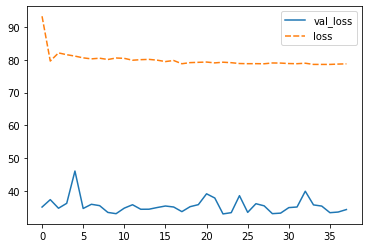

In [5]:
model_3_history = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/model_3_history.csv',
                               index_col = [0])
sns.lineplot(data = model_3_history)

Validation loss is much lower than training loss due to dropout regularization -> Dropout is activated on training but deactivated on evaluating the training set.
Model has converged faster.

#### Comparison of the model iterations on the whole dataset

In [17]:
model_histories = pd.DataFrame({'model_1_loss': model_1_history['loss'],
                                'model_2_loss': model_2_history['loss'],
                                'model_3_loss': model_3_history['loss'],
                                'model_1_val_loss': model_1_history['val_loss'], 
                                'model_2_val_loss': model_2_history['val_loss'],
                                'model_3_val_loss': model_3_history['val_loss']})

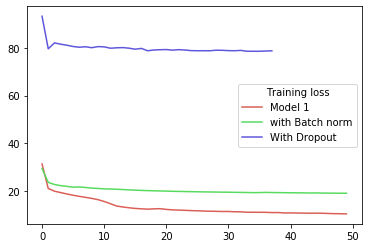

In [20]:
plot = sns.lineplot(data = [model_histories['model_1_loss'], 
                            model_histories['model_2_loss'],
                            model_histories['model_3_loss']],
                   palette=sns.color_palette("hls", 3), dashes = False)
labels = ['Model 1', 'With Batch norm', 'With dropout']
plt.legend(title = 'Training loss', labels = ['Model 1', 'with Batch norm', 'With Dropout'])

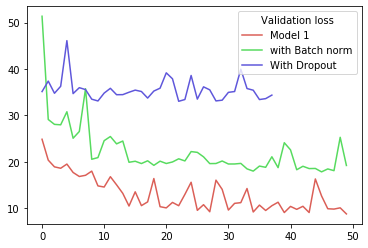

In [19]:
plot = sns.lineplot(data = [model_histories['model_1_val_loss'],
                            model_histories['model_2_val_loss'],
                            model_histories['model_3_val_loss']],
                     palette=sns.color_palette("hls", 3), dashes = False)
labels = ['Model 1', 'With Batch norm', 'With dropout']
plt.legend(title = 'Validation loss', labels = ['Model 1', 'with Batch norm', 'With Dropout'])

Obtaining parameters from the subsampled dataset hasn't proved successful. Model 1 shows the best validation and training scores, although some additional regularization is necessary.

#### Tuning the model on the full dataset with Bayesian optimization

Starting values for Bayesian optimization are taken from random and grid search

In [1]:
def model_bayes(dropout_rate_1, dropout_rate_2, lr, epsilon, neurons):
    K.backend()
    model = Sequential()
    
    #input layer
    model.add(Dense(int(X_train.shape[1]), input_dim = int(X_train.shape[1])))
    model.add(Activation('relu'))
    model.add(Dropout(rate = dropout_rate_1))
    
    #hidden layer
    model.add(Dense(neurons))
    model.add(Activation('relu'))
    model.add(Dropout(rate = dropout_rate_2))

    
    #output layer
    model.add(Dense(1, kernel_initializer = 'he_normal'))
    adam = optimizers.Adam(lr = lr, epsilon = epsilon)
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model

Defining the distribution for the tuning parameters

In [4]:
dropout_rate_1 = Real(low = 0.0, high = 0.9, prior = 'uniform', name = 'dropout_rate_1')
dropout_rate_2 = Real(low = 0.0, high = 0.9, prior = 'uniform', name = 'dropout_rate_2')
lr = Real(low = 1e-4, high = 1e-1, prior = 'log-uniform', name = 'lr')
epsilon = Real(low = 1e-8, high = 1e-1, prior = 'log-uniform', name = 'epsilon')
neurons = Integer(low = 2, high = 50, name = 'neurons')

In [5]:
dimensions = [dropout_rate_1, dropout_rate_2, lr, epsilon, neurons]
default_parameters = [0.4, 0.4, 0.01, 1e-8, 38]

Defining a fitness function that is minimized

In [8]:
@use_named_args(dimensions=dimensions) #decorator allows objective function to recive the parameters as keyword arguments
def fitness(dropout_rate_1, dropout_rate_2, lr, epsilon, neurons):
    model = model_6_5(dropout_rate_1,dropout_rate_2,lr,epsilon,neurons)
    model.fit(X_train, y_train, epochs = 50)
    y_pred = model.predict(X_test)
    mean_absolute_error = mae(y_test, y_pred)
    return mean_absolute_error

Running the minimization algorithm

In [ ]:
bayesian_search = gp_minimize(func = fitness,
                              dimensions = dimensions,
                              acq_func = 'EI',
                              n_calls = 11,
                              x0 = default_parameters,
                              random_state=0)

In [9]:
bayesian_results = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/bayesian_results.csv',
                              index_col = 0)

In [10]:
bayesian_results

,bayes_mae,dropout_rate_1,dropout_rate_2,lr,epsilon,neurons
0,2.610683,0.134707,0.200089,0.001444,0.020806,24


Results from the bayesian search. The final model performs worse than the model with the default parameters, due to small number of steps in the optimization. 

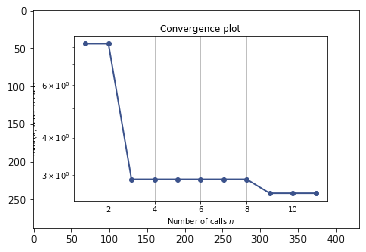

In [16]:
bayesian_opt_plot = mpimg.imread('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/bayesian_convergence.png')
imgplot = plt.imshow(bayesian_opt_plot)

## Training of the final model on the whole training set

In [1]:
def model_final():
    K.backend()
    model = Sequential()
    
    #input layer
    model.add(Dense(int(X_train.shape[1]), input_dim = int(X_train.shape[1])))
    model.add(Activation('relu'))
    
    #hidden layer
    model.add(Dense(int(X_train.shape[1]/2)))
    model.add(Activation('relu'))

    
    #output layer
    model.add(Dense(1))
    adam = optimizers.Adam()
    model.compile(loss = 'mean_squared_error', optimizer= adam)
    return model

In [ ]:
early_stopper = EarlyStopping(monitor = 'val_loss', min_delta = 0.0001, patience = 15, restore_best_weights = True)
model = model_final()
history_model_final = model.fit(X_train, y_train, 
                                callbacks = [early_stopper], validation_data = (X_test, y_test), 
                                epochs = 100)

In [8]:
model_final_history_df = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_final_history2.csv', index_col = 0)
model_final_mae_df = pd.read_csv('/home/dionizije/Desktop/Code/Predicting molecular properties/Models_final/Model_final_mae2.csv', index_col = 0)

Final MAE is model_final_mae    1.933333
Name: 0, dtype: float64


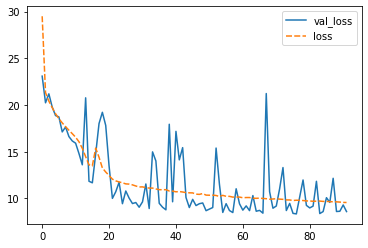

In [11]:
sns.lineplot(data = model_final_history_df)
print('Final MAE is {}'.format(model_final_mae_df.iloc[0]))

Final mean absolute error is 1.933, neglibile difference between 50 or more epochs.

In [1]:
%%html
<script src="https://cdn.rawgit.com/parente/4c3e6936d0d7a46fd071/raw/65b816fb9bdd3c28b4ddf3af602bfd6015486383/c